In [10]:
import numpy as np
import os
import pathlib
import random
import torch
import pytorch3d.transforms
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


In [11]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [12]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

def getLinkInitialLength(linkName):
    linkObject = learnable_robot_model._get_parent_object_of_param(linkName, "trans")
    return linkObject.trans().detach().clone()

def makeLinkLengthLearnable(linkName, value = None):
    linkObject = learnable_robot_model._get_parent_object_of_param(linkName, "trans")
    learnable_robot_model.make_link_param_learnable(
        linkName, 
        "trans", 
        UnconstrainedTensor(dim1 = 1, dim2 = 3, init_tensor = value)
    )
    print(f"Made {linkName} link's length learnable initialized tensor to {value}")

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

intialJointAngles = {joint: getLinkInitialLength(joint) for joint in learnable_robot_model.get_link_names()}

for joint in intialJointAngles:
    makeLinkLengthLearnable(joint, intialJointAngles[joint].detach().clone())

Made base link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made trunk link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made imu_link link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made FR_hip link's length learnable initialized tensor to tensor([[ 0.181, -0.047,  0.000]])
Made FR_thigh_shoulder link's length learnable initialized tensor to tensor([[ 0.000, -0.081,  0.000]])
Made FR_thigh link's length learnable initialized tensor to tensor([[ 0.000, -0.084,  0.000]])
Made FR_calf link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FR_foot link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FL_hip link's length learnable initialized tensor to tensor([[0.181, 0.047, 0.000]])
Made FL_thigh_shoulder link's length learnable initialized tensor to tensor([[0.000, 0.081, 0.000]])
Made FL_thigh link's length learnable initialized tensor to tensor([[0.000, 0.084, 0.00

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [13]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")

image_robot_mapping = [
['FL_Ankle', "FL_foot"],
['FR_Ankle', "FR_foot"],
['FL_Knee', "FL_calf"],
['FR_Knee', "FR_calf"],
['BL_Ankle', "RR_foot"],
['BR_Ankle', "RL_foot"],
['BL_Knee', "RR_calf"], 
['BR_Knee', "RL_calf"], 
["Hip", "RR_thigh"], 
["Hip", "RL_thigh"], 
["Shoulder","FL_thigh"],
["Shoulder","FR_thigh"],
]
                       
training_keypoints = [imageToRobotPair[0] for imageToRobotPair in image_robot_mapping]
robot_joints_for_training = [imageToRobotPair[1] for imageToRobotPair in image_robot_mapping]
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
trainingDataDirectory = base_dir / "HorseInferenceFiles"

#Open video, if that fails stop the flow
video = cv2.VideoCapture(str(trainingDataDirectory/"trainset/trimmedHorseVideo.mp4"))
if not video.isOpened():
    assert False, "Video failed to open"

startingFrame = 100
numberOfFramesToTrainOn = 5

video.set(cv2.CAP_PROP_POS_FRAMES, startingFrame)

dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
poses = []
images = []
imgCount = numberOfFramesToTrainOn
for index in range(numberOfFramesToTrainOn):
    _,image = video.read()    
    images.append(image)
    if index == 0:
        pose = dlc_live.init_inference(image)
    else:
        pose = dlc_live.get_pose(image)
    pose = pose[indices_keypoints_training][:,0:2]
    pose = torch.from_numpy(pose).unsqueeze(0)
    poses.append(pose)
images = np.array(images)
video.release()
# X,Y coords of selected keypoints
training_data = torch.vstack(poses)
training_data.shape

torch.Size([5, 12, 2])

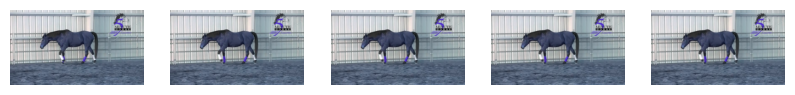

In [14]:
fig, axarr = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for i in range(len(images)):
    axarr[i].imshow(images[i]) 
    axarr[i].axis('off') 
plt.show()

In [15]:
def homogenize_vectors(tensor, padding_size = 1):
  padded_tensor = torch.nn.functional.pad(
      tensor, pad=(0, padding_size), mode='constant', value=1)
  return padded_tensor

def dehomogenize_vector(tensor, padding_size=1):
  cropped_tensor = tensor[..., :-padding_size]
  return cropped_tensor

## Training Loop

Made base link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made trunk link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made imu_link link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made FR_hip link's length learnable initialized tensor to tensor([[ 0.181, -0.047,  0.000]])
Made FR_thigh_shoulder link's length learnable initialized tensor to tensor([[ 0.000, -0.081,  0.000]])
Made FR_thigh link's length learnable initialized tensor to tensor([[ 0.000, -0.084,  0.000]])
Made FR_calf link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FR_foot link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FL_hip link's length learnable initialized tensor to tensor([[0.181, 0.047, 0.000]])
Made FL_thigh_shoulder link's length learnable initialized tensor to tensor([[0.000, 0.081, 0.000]])
Made FL_thigh link's length learnable initialized tensor to tensor([[0.000, 0.084, 0.00

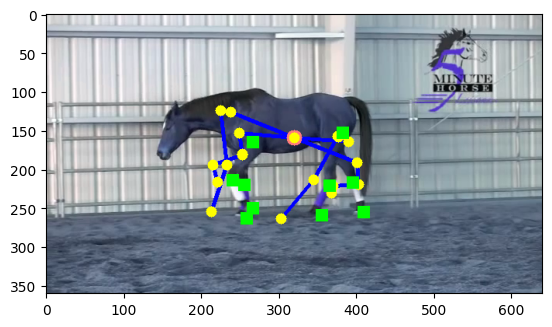

Epoch 100: Loss (321.1102600097656), Loss Per Entry (5.833745002746582 pixels)


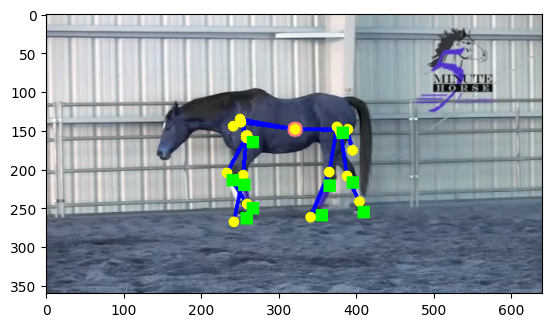

Epoch 200: Loss (212.85360717773438), Loss Per Entry (4.027792453765869 pixels)


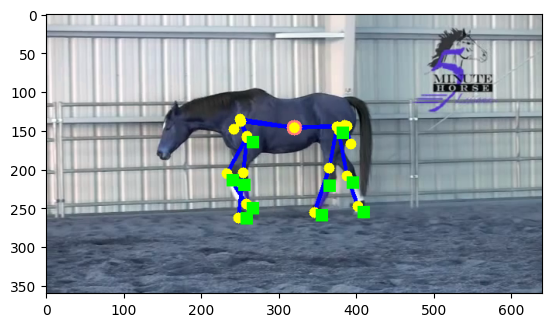

Epoch 300: Loss (174.59652709960938), Loss Per Entry (3.3907651901245117 pixels)


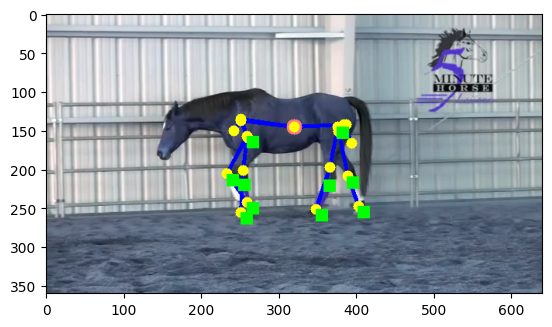

Epoch 400: Loss (124.94387817382812), Loss Per Entry (2.567901611328125 pixels)


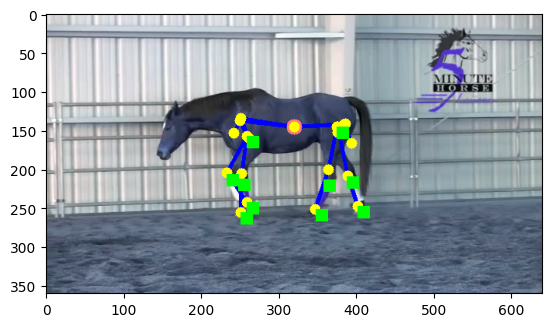

Epoch 500: Loss (66.55087280273438), Loss Per Entry (1.6012005805969238 pixels)


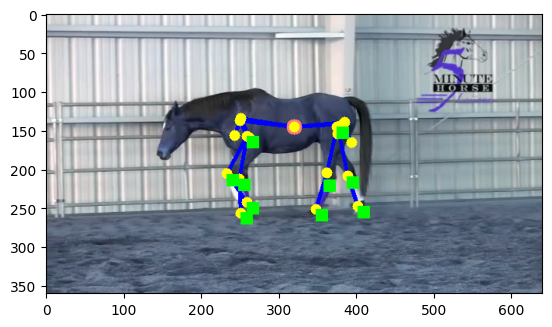

Epoch 600: Loss (35.24915313720703), Loss Per Entry (1.0848262310028076 pixels)


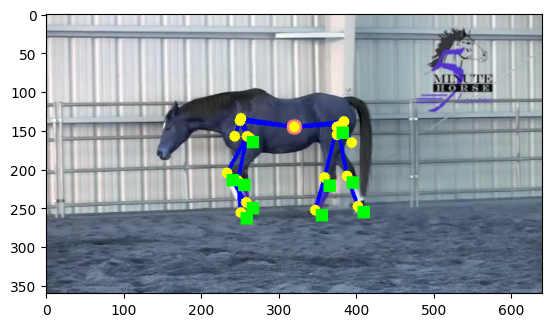

Epoch 700: Loss (18.78117561340332), Loss Per Entry (0.8118153214454651 pixels)


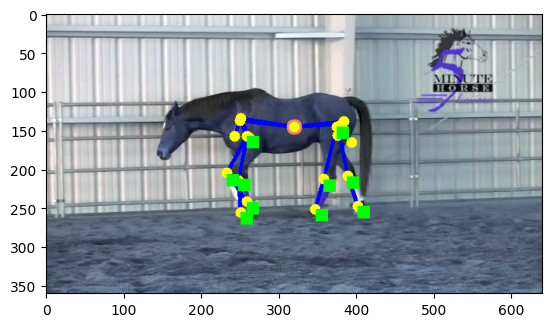

Epoch 800: Loss (19.69401741027832), Loss Per Entry (0.8271028995513916 pixels)


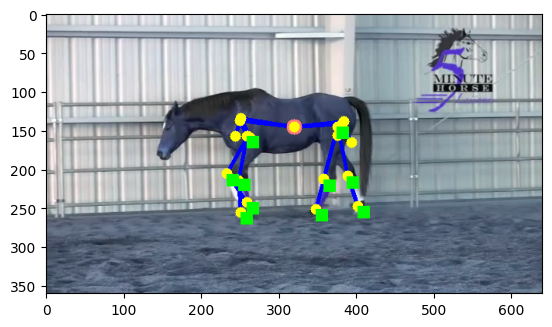

Epoch 900: Loss (20.58233070373535), Loss Per Entry (0.8416944742202759 pixels)


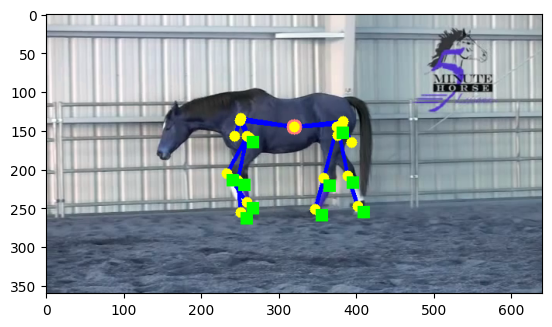

In [41]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]

#Resets robot limb lengths to those from URDF
for joint in intialJointAngles:
    makeLinkLengthLearnable(joint, intialJointAngles[joint].detach().clone())

init_angles = torch.tensor([ 0.904,  0.086, -0.348, -0.369, -0.085,  0.513,  0.751, -0.346, -0.121,
         -0.557, -0.003,  0.355])
init_angles = init_angles.repeat(imgCount,1)
joint_angles = init_angles.requires_grad_(True)

constantTensor = lambda constant: torch.tensor(float(constant))
differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)

fx = differentiableConstantTensor(-320)
fy  = differentiableConstantTensor(320)
u0 = differentiableConstantTensor(320)
v0 = differentiableConstantTensor(160)



tx = torch.ones((imgCount,))*0
tx = tx.requires_grad_(True)
ty = torch.ones((imgCount,))*0
ty = ty.requires_grad_(True)
tz = torch.ones((imgCount,))*1
tz = tz.requires_grad_(True)

#Zero rotation quaternion
#Good visualization resource: https://quaternions.online
extrinsicRotationQuaternion = torch.tensor([0.55, 0.3, 0.1, -0.1])
extrinsicRotationQuaternion = extrinsicRotationQuaternion.unsqueeze(0) * torch.ones((imgCount,4))
extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)

%matplotlib inline
VERBOSE = True
optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-3)
# optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles], lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
robotEEPositions = None
trainingFrames = []
for epoch in range(1000):
    optimizer.zero_grad()
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(imgCount,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    #If Only One Entry Duplicate Data
    for jointName in robotEEPositions:
        if robotEEPositions[jointName].shape[0] == imgCount:
            continue
        robotEEPositions[jointName] = robotEEPositions[jointName].repeat(imgCount,1)
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_for_training])
    def calculateCameraProjection(intrinsic, extrinsic, jointPositions):
        transform = intrinsic@extrinsic
        pixelPositions = transform@(homogenize_vectors(jointPositions).transpose(1,2))
        pixelPositions = pixelPositions.transpose(1,2)
        pixelPositions = dehomogenize_vector(pixelPositions)
        return pixelPositions
    jointCameraPositions = calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    pixelLoss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data).reshape(-1,2)), 2),-1)))

    def interframeJointLoss(jointAngles):
        """
            The L2 norm computed for every joint. Measures frame by frame the changes in joint angles, to minimze it
        """
        epsilon = 1.e-8
        return torch.sum(torch.sqrt(torch.sum(torch.pow(jointAngles[1:] - jointAngles[:-1],2), -1) + epsilon))
    #Experimentally Ive seen it ranges it has a magnitude in the e-1's
    jointLoss = interframeJointLoss(joint_angles)

    def totalLimbLength(relu = False, reluThreshold = 0.1):
        """
            Returns the length of all of the links of the robot
        """
        #TODO: Fixing initialization to have the robot's legs down in the image
        robotLinks = torch.vstack([learnable_robot_model._get_parent_object_of_param(joint, "trans").trans().detach().clone() for joint in learnable_robot_model.get_link_names()])
        distances = (torch.sqrt(torch.sum(torch.pow(robotLinks,2),-1)))
        if relu:
            distances = torch.nn.functional.relu(distances - reluThreshold)
        return torch.sum(distances)
    limbLengthLoss = totalLimbLength()

    loss = pixelLoss + 10*limbLengthLoss + jointLoss

    def drawPredictionOnImage(imageIndex = 0):
        img = (images[imageIndex]).copy()
        positionByJoint = torch.cat([v[imageIndex].unsqueeze(0) if len(v.shape) >= 2 else v.unsqueeze(0) for v in robotEEPositions.values()])
        #
        allJointPosiitons = calculateCameraProjection(intrinsic, extrinsic, positionByJoint.unsqueeze(0).repeat(imgCount,1,1))[0]
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Links
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.clone().detach().numpy())
            end = tuple(end.clone().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//4)
        #Draw Robot Joints
        for joint in jointToCameraPosition:
            jointPositionTensor = jointToCameraPosition[joint]
            color = (255,255,0)
            dotSize = size//2
            if joint == "base":
                color = (255,124,124)
                dotSize = int(dotSize*1.5)
            jointPosition = jointPositionTensor.clone().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),dotSize,color,-1)
        #Draw Keypoints
        for x,y in training_data[imageIndex]:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        return img

    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss}), Loss Per Entry ({loss/jointCameraPositions.reshape(-1,2).shape[0]} pixels)")
    trainingFrames.append(drawPredictionOnImage(0))
    n = 100
    if epoch % n == 0 and VERBOSE:        
        plt.clf()
        plt.imshow(trainingFrames[-1])
        plt.show()
    loss.backward()
    optimizer.step()


In [39]:
joint_angles

tensor([[ 0.904,  0.086, -0.348, -0.369, -0.085,  0.513,  0.751, -0.346, -0.121,
         -0.557, -0.003,  0.355],
        [ 0.902,  0.108, -0.339, -0.377, -0.141,  0.459,  0.779, -0.324, -0.138,
         -0.579,  0.014,  0.353],
        [ 0.902,  0.108, -0.339, -0.377, -0.141,  0.459,  0.780, -0.324, -0.138,
         -0.580,  0.015,  0.353],
        [ 0.902,  0.108, -0.339, -0.377, -0.141,  0.459,  0.781, -0.324, -0.139,
         -0.580,  0.016,  0.354],
        [ 0.902,  0.109, -0.339, -0.377, -0.140,  0.459,  0.781, -0.323, -0.138,
         -0.579,  0.016,  0.354]], requires_grad=True)

In [42]:
#Export video of training
vidOut = cv2.VideoWriter('training_video.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 30, (640,360))
for frame in trainingFrames:
    vidOut.write(frame)
vidOut.release()

In [43]:
#Export video of the frames
vidOut = cv2.VideoWriter('final_video.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 10, (640,360))
for index in range(len(images)):
    vidOut.write(drawPredictionOnImage(index))
vidOut.release()